# Generic Box
This code communicates with a component. The component was launched with the command below from the root of the repository:

```shell
$ docker run --rm -it -p 4061:8061 -v ./src/external1.py=/workspace/external.py generic
```


In [1]:
import argparse
import grpc
import io
import matplotlib.pyplot as plt
#In case of importing files from other directory
from importlib.machinery import SourceFileLoader

# add a folder to the system path
import sys
sys.path.append("../protos")
import pipeline_pb2 as vggt_pb2
import pipeline_pb2_grpc as vggt_pb2_grpc
from aux import wrap_value, unwrap_value

import PIL.Image as PIL_image
import numpy as np
import cv2
from scipy.io import loadmat,savemat


## Set parameters (GRPC) and data
Set IP and port of the service (the same used in docker run), input data (image in a matfile) and call the service

In [2]:
from PIL import Image
import json

#target='printart.isr.ist.utl.pt:8061'
target='localhost:8061'
# List of file paths (example paths — replace with your actual ones)
file_paths = [
    'images/00.jpg',
    'images/01.jpg',
]

#list all files in a certain directory
import os
directory = "/home/manuelf/mast3r/images_in/piv"
#file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))][0:1]

# List to hold the binary data of each image
image_byte_list = []
for path in file_paths:
    # Open the file in binary read mode ('rb') and read its entire content
    with open(path, 'rb') as f:
        image_bytes = f.read()
        image_byte_list.append(image_bytes)
        print(f"Read {path}: {len(image_bytes) / (1024 * 1024):.2f} MB")

config_json = {
    "aispgradio": {
        "command": "3d_infer",
        "parameters": {
            "device": "cuda:0", # TODO: implement this
            "conf_vis": 50.0
        }
    }
}

request = vggt_pb2.Envelope(data={"images":wrap_value(image_byte_list)},
                            config_json = json.dumps(config_json))

#Para imagens muito grandes buffer grande
channel_opt = [('grpc.max_send_message_length', -1), ('grpc.max_receive_message_length', -1)]
channel=grpc.insecure_channel(target,options=channel_opt)
estimator_stub = vggt_pb2_grpc.PipelineServiceStub(channel)

Read images/00.jpg: 0.16 MB
Read images/01.jpg: 0.16 MB


In [3]:
#Name of the method in the service
response = estimator_stub.Process(request)
#After finishing channel.close

In [ ]:
unwrap_value(response.data["images"])[0]

80

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.060561467..1.0294862].


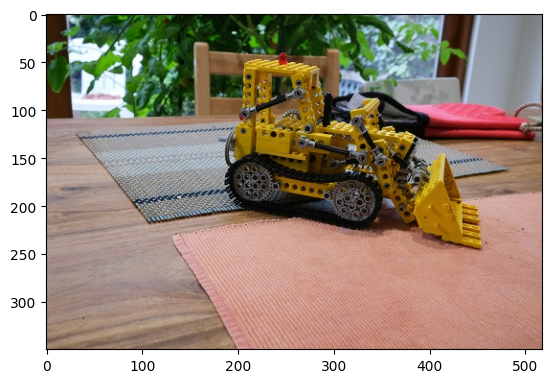

In [17]:
import torch

def bytes_to_tensor(b: bytes) -> torch.Tensor:
    return torch.load(io.BytesIO(b))

depthmap = bytes_to_tensor(unwrap_value(response.data["depth"]))
ims_tensor = bytes_to_tensor(unwrap_value(response.data["images"]))

plt.imshow(ims_tensor[0,...].numpy().transpose(1,2,0))

